<a href="https://colab.research.google.com/github/marco-finger/derLauch/blob/main/CodingTask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Science Fundamentals for DCBP, S. Haug, University of Bern 

# Coding Task 1

- Deadline (upload to Ilias): 2022-03-20 24:00
- Estimated effort: 2-5 hours
- Data on Ilias (4ms_...) with metadata file CCD-Metadata


## Tasks (maximum 12.5 points)

- Write a method (function) which removes the header information in the datafile and saves that information into a separate textfile. [0.5 points] 
- Write a function which reduces the data resolution by averaging over 1, 2, 3 and 4 nm wavelengths. Save these 4 new reduced datasets in new files. Do this (1) by writing an explicit loop and (2) by using pandas methods. Measure the running times of the two approaches. [6 points]
- Write a function which takes two wavelengths as input and plots the difference of the data at these lengths over time. [2 points] 
- Let the x-axis be in seconds, label the axes with names and units, label the plot with color and legend, make a title for the plot. Save the plot to a file. [2 points]
- Plot the full and the reduced datasets in the same figure. Is there any visual difference? [2 points]

In [ ]:
# import of standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# mount dataset from Google drive
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/DSF-FS22/data/task1/4ms_10 av_30 s_Absorbance_10-32-04-868.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# studying dataframe
# df.info()
# df.describe()
# df.head()
# df.tail()

### 1. Removing header (0.5 points)

#### Old approach

In [ ]:
# df = pd.read_csv(path, delimiter='\t', header = 13) # header taken as from row 13 
# df = df.drop(columns = "Unnamed: 0") # removes the redundant first column
# df.to_csv('/content/drive/MyDrive/DSF-FS22/data/task1/CCD-Data.csv') # creates a csv file containg only the data and saves it into a folder called "task1"
# df = df.rename(columns={"Unnamed: 1": "time"}) # calling first column "time"

#### New approach

In [ ]:
def remove_header(path): # function that removes the header (argument = path)
    header = [] # empty list
    try: # see https://docs.python.org/3/tutorial/errors.html for the try-clause 
        file = open(path, encoding = 'utf-8') # for meaning of utf-8, see: https://en.wikipedia.org/wiki/UTF-8
        for line in iter(file.readline, b''): # iteration over header columns; see https://stackoverflow.com/a/12944855
            if line == ">>>>>Begin Spectral Data<<<<<\n": # start of the spectrum; looking for the indicated string in the csv file
                break # see notebook 03_Basic_Python_2.ipynb
            header.append(line) # appends lines to header
    finally: # see: https://www.geeksforgeeks.org/try-except-else-and-finally-in-python/ for finally-clause
        file.close() # https://www.tutorialspoint.com/python/file_close.htm (close method)
    return header # output of code

In [ ]:
header = remove_header("/content/drive/MyDrive/DSF-FS22/data/task1/4ms_10 av_30 s_Absorbance_10-32-04-868.txt")

In [ ]:
def save_header(header, path): # function to save header information as a seperate file
    try:
        file = open(path, 'w', encoding = 'utf-8') # utf-8 encoded text file
        for line in header: # iteration over all header lines
            file.write(line) # writes a file with the respective lines
    finally:
        file.close()

In [ ]:
save_header(header, '/content/drive/MyDrive/DSF-FS22/data/task1/CCD-Header.csv') # saves the header information into file called "CCD-Header.csv"

In [ ]:
def split_data(path, filename): # function that splits the original csv file into header and pure data
    lines = [] # empty list for lines

    # Split file into header and data
    try:
        file = open(path + filename, encoding = 'utf-8')
        # read and store all lines into list
        lines = file.readlines()
        file.close() # documentation see: https://www.programiz.com/python-programming/methods/built-in/open
        # Open header file
        file = open(path + 'CCD-Header.csv', 'w', encoding = 'utf-8')
        for line in lines:
            if line == ">>>>>Begin Spectral Data<<<<<\n":
                # Switch to data file
                file.close()
                file = open(path + 'CCD-Data.csv', 'w', encoding = 'utf-8')
                continue
            file.write(line)
    finally:
        file.close()

In [ ]:
split_data("/content/drive/MyDrive/DSF-FS22/data/task1/", "4ms_10 av_30 s_Absorbance_10-32-04-868.txt") # saves split data under path indicated

### 2. Reducing data resolution (6 points)


#### Loop approach

In [ ]:
wavelengths = [] # empty list for wavelengths
try:
    f = open("/content/drive/MyDrive/DSF-FS22/data/task1/" + "CCD-Data.csv") # where to grap the data
    # remove the first two values and convert to float by applying a map function
    wavelengths = list(map(float, f.readline().split("\t")[2:])) # wavelengths start with index 2
finally:
    f.close()

# map functions: https://www.geeksforgeeks.org/python-map-function/    

In [ ]:
wavelengths[0:10] # call the wavelengths saved as a list

[316.6137,
 316.7492,
 316.8847,
 317.0203,
 317.1558,
 317.2913,
 317.4268,
 317.5623,
 317.6977,
 317.8332]

In [ ]:
def extract_indices(wavelengths, binning_value): # binning_value means data resolution
    indices = [0]
    for index, wavelength in enumerate(wavelengths): # interation through a list using the enumerate() method
        if (int(wavelength) - int(wavelengths[indices[-1]]) < binning_value): # float to int conversion; binning wavelength indices within "binning_value"
            continue
        indices.append(index)
    return indices

In [ ]:
indices = extract_indices(wavelengths, 4) # try with 4nm resolution

In [ ]:
zipped_indices = list(zip(indices, indices[1:])) # https://note.nkmk.me/en/python-for-enumerate-zip/ geting elements for lists

In [ ]:
zipped_indices[:4]

[(0, 25), (25, 55), (55, 85), (85, 114)]

In [ ]:
def aggregate_explicit(path, data_filename, indices):
    lines = []
    # Split file into header and data
    try:
        file = open(path + data_filename, encoding = 'utf-8')
        # read and store all lines but first into list
        lines = file.readlines()[1:]
        file.close()
        file = open(path + "CCD-Data_aggregated.txt", 'w', encoding = 'utf-8')
        for line in lines:
            # extract values
            values = line.split("\t")
            # write timestamps
            file.write("\t".join(values[:2]))
            # skip timestamp and convert values to float
            values = list(map(float, values[2:]))
            for (start, end) in indices:
                file.write("\t")
                # calculate mean
                value = sum(values[start:end]) / (end - start)
                file.write(str(value))
            file.write("\n")
    finally:
        file.close()

In [ ]:
aggregate_explicit("/content/drive/MyDrive/DSF-FS22/data/task1/", "CCD-Data.csv", zipped_indices) 

In [ ]:
# measuring run time of the loop approach
%%timeit -n 10000 -r 5      

def explicit_aggregate_wavelengths(path, data_filename, binning_value):
    try:
        file = open(path + data_filename)
        # remove the first two values and convert to float by applying a map function
        wavelengths = list(map(float, file.readline().split("\t")[2:]))
        indices = [0]
        for index, wavelength in enumerate(wavelengths):
            if (int(wavelength) - int(wavelengths[indices[-1]]) < binning_value):
                continue
            indices.append(index)
        zipped_indices = list(zip(indices, indices[1:]))
        lines = file.readlines()
        file.close()
        file = open(path + "CCD-Data_" + str(binning_value) + "nm.txt", 'w', encoding = 'utf-8')
        for line in lines:
            # extract values
            values = line.split("\t")
            # write timestamps
            file.write("\t".join(values[:2]))
            # skip timestamp and convert values to float
            values = list(map(float, values[2:]))
            for (start, end) in zipped_indices:
                file.write("\t")
                # calculate mean
                value = sum(values[start:end]) / (end - start)
                file.write(str(value))
            file.write("\n")
    finally:
        f.close()   

10000 loops, best of 5: 73.1 ns per loop


In [ ]:
for i in [1,2,3,4]: # for binning with resolutions of 1-4 nm
    explicit_aggregate_wavelengths("/content/drive/MyDrive/DSF-FS22/data/task1/", "CCD-Data.csv", i)

#### Pandas approach

In [ ]:
df = pd.read_table("/content/drive/MyDrive/DSF-FS22/data/task1/CCD-Data.csv")
df

,Unnamed: 0,Unnamed: 1,316.6137,316.7492,316.8847,317.0203,317.1558,317.2913,317.4268,317.5623,...,778.9703,779.089,779.2076,779.3263,779.4449,779.5636,779.6822,779.8008,779.9194,780.0381
0,2018-10-25 10:32:04.789000,1540456324789,0.329672,0.329672,0.329672,0.090294,-0.716926,-1.829304,-0.686330,-0.428776,...,-0.038483,-0.039623,-0.036920,-0.037309,-0.037299,-0.037476,-0.036856,-0.036853,-0.039100,-0.035545
1,2018-10-25 10:32:04.878000,1540456324878,-0.044412,-0.044412,-0.044412,0.157632,-0.672423,-2.183981,-0.492421,-0.000000,...,-0.039428,-0.038486,-0.037309,-0.036357,-0.037289,-0.038728,-0.037214,-0.036902,-0.040210,-0.038165
2,2018-10-25 10:32:04.962000,1540456324962,0.338219,0.338219,0.338219,0.330993,-0.879836,-0.000000,-0.559845,-0.000000,...,-0.037725,-0.037534,-0.036560,-0.036152,-0.036554,-0.036875,-0.037351,-0.036746,-0.038686,-0.036903
3,2018-10-25 10:32:05.046000,1540456325046,-0.049682,-0.049682,-0.049682,0.519086,-0.681150,-0.000000,-0.417230,-0.000000,...,-0.037613,-0.037168,-0.036369,-0.034549,-0.036252,-0.037948,-0.036713,-0.035706,-0.038203,-0.036822
4,2018-10-25 10:32:05.129000,1540456325129,0.335086,0.335086,0.335086,-0.041393,-0.000000,-1.802774,-0.510417,-0.000000,...,-0.040919,-0.038288,-0.035840,-0.035638,-0.039504,-0.040093,-0.039953,-0.037656,-0.038082,-0.035900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,2018-10-25 10:32:34.404000,1540456354404,-0.048929,-0.048929,-0.048929,-0.052674,-0.739370,-2.155336,-0.520450,-0.000000,...,-0.038112,-0.036615,-0.035938,-0.034245,-0.035340,-0.037055,-0.035771,-0.036557,-0.037451,-0.033582
351,2018-10-25 10:32:34.488000,1540456354488,0.851907,0.851907,0.851907,-0.111298,-0.639166,-2.039414,-0.531784,-0.000000,...,-0.036887,-0.036921,-0.035249,-0.033394,-0.035231,-0.035815,-0.037457,-0.035020,-0.038338,-0.035408
352,2018-10-25 10:32:34.576000,1540456354576,0.329255,0.329255,0.329255,0.064351,0.316582,-2.107210,-0.298427,0.570461,...,-0.037311,-0.036231,-0.037977,-0.033525,-0.035225,-0.036255,-0.036670,-0.036079,-0.038006,-0.035039
353,2018-10-25 10:32:34.660000,1540456354660,0.330061,0.330061,0.330061,0.081473,-0.525273,-1.750123,-0.134352,0.243550,...,-0.036267,-0.036341,-0.037307,-0.035010,-0.036073,-0.036282,-0.036911,-0.036554,-0.037560,-0.034496


In [ ]:
def extract_column_names(df, binning_value):
    #skip timestamps
    columns = df.columns[2:]
    wavelengths = []
    indices = [0]                         
    column_names = {}
    column_names[str(int(float(columns[0])))] = []
    for index, column in enumerate(columns):
        if (int(float(column)) - int(float(columns[indices[-1]])) < binning_value):
            column_names[str(int(float(columns[indices[-1]])))].append(column)
            continue
        column_names[str(int(float(column)))] = [column]
        indices.append(index)
    return column_names

In [ ]:
column_names = extract_column_names(df, 1)

In [ ]:
agg = pd.DataFrame() # aggregated data set
for (col, values) in column_names.items():
    agg[col] = df[values].agg("mean", axis="columns")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
agg

,316,317,318,319,320,321,322,323,324,325,...,771,772,773,774,775,776,777,778,779,780
0,0.329672,-0.166957,-0.064746,0.133130,0.123705,-0.249831,0.271327,-0.093151,-0.123458,-0.026454,...,-0.038555,-0.038021,-0.039290,-0.038654,-0.036496,-0.038835,-0.038145,-0.038333,-0.037680,-0.035545
1,-0.044412,-0.411839,-0.133472,2.032979,-0.387814,-0.031617,0.322955,1.744725,-0.051639,-0.147937,...,-0.038100,-0.038118,-0.038622,-0.038308,-0.036896,-0.039010,-0.038400,-0.037930,-0.037812,-0.038165
2,0.338219,-0.094507,-0.024912,0.061890,-0.226986,0.107871,0.121011,-0.208504,-0.418836,0.005751,...,-0.038063,-0.038303,-0.039200,-0.038397,-0.036932,-0.038245,-0.037664,-0.037514,-0.037057,-0.036903
3,-0.049682,0.027980,-0.008338,-0.088350,0.070348,-0.013674,0.307321,0.159532,-0.047932,0.080549,...,-0.037775,-0.037678,-0.038711,-0.038133,-0.036972,-0.038177,-0.037273,-0.036996,-0.036614,-0.036822
4,0.335086,-0.162378,-0.102281,0.045717,-0.088278,0.042099,0.304675,-0.261077,-0.009424,0.153932,...,-0.038433,-0.038135,-0.038991,-0.038178,-0.037010,-0.038540,-0.038076,-0.037606,-0.038132,-0.035900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,-0.048929,-0.438802,1.870540,-0.089910,0.026243,0.046500,0.342797,-0.024736,0.087382,-0.000370,...,-0.037537,-0.036913,-0.038062,-0.037199,-0.035328,-0.037879,-0.037486,-0.036303,-0.036122,-0.033582
351,0.851907,-0.282855,-0.039069,-0.227483,-0.140185,0.055663,0.211854,-0.064256,0.039251,-0.158020,...,-0.036774,-0.036255,-0.037614,-0.037000,-0.035254,-0.037384,-0.036114,-0.035518,-0.035928,-0.035408
352,0.329255,-0.074950,0.074278,-0.053091,-0.073518,0.004167,0.393093,-0.051061,0.048273,-0.049056,...,-0.037064,-0.037087,-0.037948,-0.036972,-0.035591,-0.036524,-0.036691,-0.036766,-0.036246,-0.035039
353,0.330061,-0.260591,-0.020120,0.093793,0.100177,0.134214,0.319046,0.029385,0.033831,-0.089956,...,-0.036520,-0.036748,-0.037822,-0.036839,-0.035118,-0.037559,-0.036426,-0.036488,-0.036505,-0.034496


In [ ]:
# measuring run time of the loop approach
%%timeit -n 10000 -r 5  

def pandas_aggregate_wavelengths(path, data_filename, binning_value):
    df = pd.read_table(path + data_filename)
    #skip timestamps
    columns = df.columns[2:]
    wavelengths = []
    indices = [0]                         
    column_names = {}
    column_names[str(int(float(columns[0])))] = []
    for index, column in enumerate(columns):
        if (int(float(column)) - int(float(columns[indices[-1]])) < binning_value):
            column_names[str(int(float(columns[indices[-1]])))].append(column)
            continue
        column_names[str(int(float(column)))] = [column]
        indices.append(index)
    agg = pd.DataFrame()
    for (col, values) in column_names.items():
        agg[col] = df[values].agg("mean", axis="columns")
    # reappend timestamps
    agg.insert(0, df.columns[0], df[df.columns[0]])
    agg.insert(1, df.columns[1], df[df.columns[1]])
    # Write to file
    agg.to_csv(path + "CCD-Data_pandas_" + str(binning_value) + "nm.txt", header=None, index=None, sep='\t')

10000 loops, best of 5: 74.8 ns per loop


In [ ]:
for i in [1,2,3,4]:
    pandas_aggregate_wavelengths("/content/drive/MyDrive/DSF-FS22/data/task1/", "CCD-Data.csv", i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  exec(code_obj, self.user_global_ns, self.user_ns)


### 3. Wavelength difference function (2 points)

In [ ]:
df = df.drop(columns = "Unnamed: 0") # removes the redundant first column
df = df.rename(columns={"Unnamed: 1": "time"}) # calling first column "time"

In [ ]:
# rescaling the time column
time = df.iloc[:,0]
time_zero = time[0]
for i in range(len(time)):
 time[i] = time[i] - time_zero

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### 4. Plotting wavelengths over time (2 points)

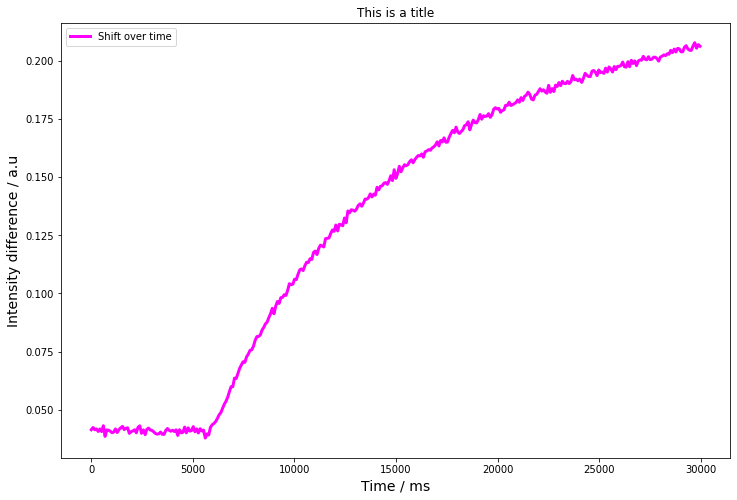

In [ ]:
y = -(df.iloc[:,1950]-df.iloc[:,1800]) # takes two wavelengths with indices 1950 and 1800

plt.figure(figsize = (12,8)) # modify picture size
plt.plot(time, y, color = "magenta", label = 'Shift over time', lw = 3) # plot of the difference in intensity at two wavelengths over time
plt.xlabel('Time / ms', size = 14) # x-label
plt.ylabel('Intensity difference / a.u', size = 14) # y-label
plt.legend()
plt.title('This is a title')
plt.savefig('/content/drive/MyDrive/DSF-FS22/data/task1/CCD-Plot.png')

### 5. Additional stuff

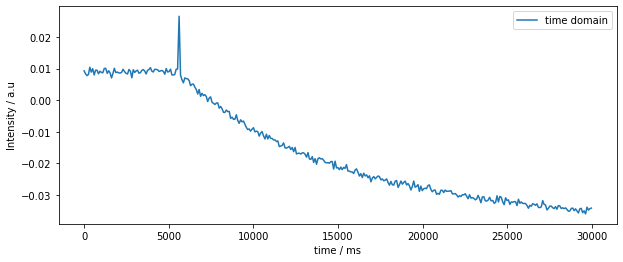

In [ ]:
# intensity over time

plt.figure(figsize = (10,4))

plt.plot(time, df.iloc[:,1950], label = "time domain") 
plt.xlabel('time / ms')
plt.ylabel('Intensity / a.u')
plt.legend()

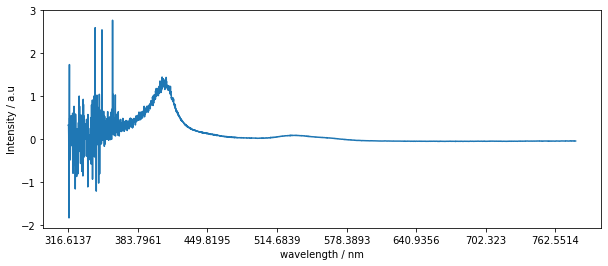

In [ ]:
# classical spectrum over wavelength


plt.figure(figsize = (10,4))
plt.xlabel('wavelength / nm')
plt.ylabel('Intensity / a.u')
df1 = df.iloc[0,1:-1]
df1.plot()

# Disclaimer

This notebook was created by Marco Finger and Gianluca Righetti.

Considering parts 1 and 2, we had significant help from a colleague and we would like to express our graditude for his support.